<a href="https://colab.research.google.com/github/manabtikadar/ReinforcementLearning/blob/main/OpenAI_Gym_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%bash
# This Cell is only used to make sure cartpole runs

# install required system dependencies
apt-get install -y xvfb x11-utils

# install required python dependencies (might need to install additional gym extras depending)
pip install pyvirtualdisplay PyOpenGL PyOpenGL-accelerate

Reading package lists...
Building dependency tree...
Reading state information...
x11-utils is already the newest version (7.7+5build2).
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.13).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.


In [ ]:
import pyvirtualdisplay

_display = pyvirtualdisplay.Display(visible=0,size=(1400,900))

_ = _display.start()

In [ ]:
# this is a Deep Q Learning (DQN) agent including replay memory and a target network
# you can write a brief 8-10 line abstract detailing your submission and experiments here
# the code is based on https://github.com/seungeunrho/minimalRL/blob/master/dqn.py, which is released under the MIT licesne
# make sure you reference any code you have studied as above, with one comment line per reference
import gym
import collections
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

# hyperparameters
learning_rate = 0.0005
gamma         = 0.98
buffer_limit  = 50000
batch_size    = 32
video_every   = 25
print_every   = 5


# The ReplayBuffer class is typically used in reinforcement learning (RL) to store and sample past experiences (state, action, reward, next state) for training
class ReplayBuffer():
  def __init__(self):
    self.buffer = collections.deque(maxlen=buffer_limit)

  def put(self, transition):
    self.buffer.append(transition) #A transition is a tuple: (state, action, reward, next_state, done_mask)

  def sample(self,n):
    mini_batch = random.sample(self.buffer, n)
    s_lst, a_lst, r_lst, s_prime_lst, done_mask_lst = [], [], [], [], []

    for transition in mini_batch:
      s, a, r, s_prime, done_mask = transition
      s_lst.append(s)
      a_lst.append([a])
      r_lst.append([r])
      s_prime_lst.append(s_prime)
      done_mask_lst.append([done_mask])

    return torch.tensor(s_lst, dtype=torch.float), torch.tensor(a_lst), \
           torch.tensor(r_lst), torch.tensor(s_prime_lst, dtype=torch.float), \
           torch.tensor(done_mask_lst)

  def size(self):
    return len(self.buffer)

import torch
import torch.nn as nn
import torch.nn.functional as F
import random

class QNetwork(nn.Module):
  def __init__(self, input_size, output_size):
    super(QNetwork, self).__init__()
    self.fc1 = nn.Linear(input_size, 128)  # Input layer to hidden layer
    self.fc2 = nn.Linear(128, 128)         # Hidden layer
    self.fc3 = nn.Linear(128, output_size) # Hidden layer to output layer

  def forward(self, x):
    x = x.view(x.size(0), -1)  # Ensure proper shape
    x = F.relu(self.fc1(x))    # Apply ReLU activation
    x = F.relu(self.fc2(x))
    x = self.fc3(x)            # Output Q-values for actions
    return x

  def sample_action(self, obs, epsilon):
    out = self.forward(obs)  # Get Q-values
    coin = random.random()   # Generate a random float between 0 and 1

    if coin < epsilon:
      return random.randint(0, out.shape[-1] - 1)  # Pick a random action
    else:
      return out.argmax().item()  # Pick the action with the highest Q-value


def train(q, q_target, memory, optimizer):
  for i in range(10):
    s,a,r,s_prime,done_mask = memory.sample(batch_size)

    q_out = q(s)
    q_a = q_out.gather(1,a)
    max_q_prime = q_target(s_prime).max(1)[0].unsqueeze(1)
    target = r + gamma * max_q_prime * done_mask  # Q(s,a) = R(s,a) + γ*Q_targ(s_prime)*done_mask
    loss = F.smooth_l1_loss(q_a,target)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [ ]:
import gym
from gym.wrappers import RecordVideo
import os
import warnings
video_every   = 25

# Ensure the video directory exists
video_folder = "content/video"
os.makedirs(video_folder, exist_ok=True)

# Create environment and wrap it with RecordVideo
env = gym.make('CartPole-v1',render_mode="rgb_array")  # Use 'CartPole-v1' as 'CartPole-v0' is deprecated
env = RecordVideo(env, video_folder, episode_trigger=lambda episode_id: (episode_id % video_every) == 0)
warnings.filterwarnings("ignore", category=DeprecationWarning)

/usr/local/lib/python3.11/dist-packages/gym/wrappers/record_video.py:78: UserWarning: WARN: Overwriting existing videos at /content/content/video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


In [ ]:
env.reset()

array([ 0.04853546,  0.02379678,  0.02411671, -0.04724012], dtype=float32)

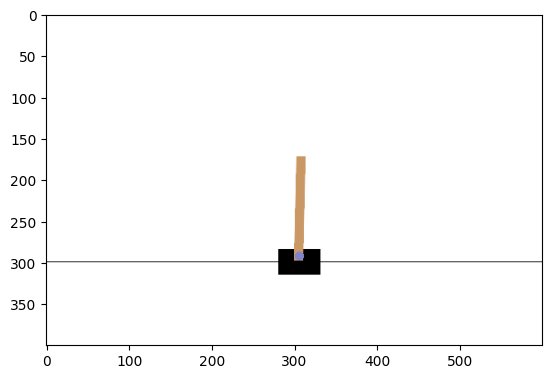

In [ ]:
plt.imshow(env.render(mode='rgb_array'))

In [ ]:
# reproducible environment and action spaces, do not change lines 6-11 here (tools > settings > editor > show line numbers)
seed = 742
torch.manual_seed(seed)
env.seed(seed)
random.seed(seed)
np.random.seed(seed)
env.action_space.seed(seed)

x = np.array(env.observation_space.shape).prod()
q = QNetwork(x, env.action_space.n)
q_target = QNetwork(np.array(env.observation_space.shape).prod(), env.action_space.n)
q_target.load_state_dict(q.state_dict())
memory = ReplayBuffer()

score    = 0.0
marking  = []
optimizer = optim.Adam(q.parameters(), lr=learning_rate)

for n_episode in range(1001):
    epsilon = max(0.01, 0.08 - 0.01*(n_episode/200)) # linear annealing from 8% to 1%
    s = env.reset()
    done = False
    score = 0.0

    while True:

        a = q.sample_action(torch.from_numpy(s).float().unsqueeze(0), epsilon)
        s_prime, r, done, info = env.step(a)
        done_mask = 0.0 if done else 1.0
        memory.put((s,a,r/100.0,s_prime, done_mask))
        s = s_prime

        score += r
        if done:
            break

    if memory.size()>2000:
        train(q, q_target, memory, optimizer)

    # do not change lines 44-48 here, they are for marking the submission log
    marking.append(score)
    if n_episode%100 == 0:
        print("marking, episode: {}, score: {:.1f}, mean_score: {:.2f}, std_score: {:.2f}".format(
            n_episode, score, np.array(marking).mean(), np.array(marking).std()))
        marking = []

    # you can change this part, and print any data you like (so long as it doesn't start with "marking")
    if n_episode%print_every==0 and n_episode!=0:
        q_target.load_state_dict(q.state_dict())
        print("episode: {}, score: {:.1f}, epsilon: {:.2f}".format(n_episode, score, epsilon))

marking, episode: 0, score: 10.0, mean_score: 10.00, std_score: 0.00
episode: 5, score: 9.0, epsilon: 0.08
episode: 10, score: 10.0, epsilon: 0.08
episode: 15, score: 10.0, epsilon: 0.08
episode: 20, score: 9.0, epsilon: 0.08
episode: 25, score: 11.0, epsilon: 0.08
episode: 30, score: 12.0, epsilon: 0.08
episode: 35, score: 10.0, epsilon: 0.08
episode: 40, score: 8.0, epsilon: 0.08
episode: 45, score: 15.0, epsilon: 0.08
episode: 50, score: 8.0, epsilon: 0.08
episode: 55, score: 8.0, epsilon: 0.08
episode: 60, score: 10.0, epsilon: 0.08
episode: 65, score: 10.0, epsilon: 0.08
episode: 70, score: 11.0, epsilon: 0.08
episode: 75, score: 8.0, epsilon: 0.08
episode: 80, score: 11.0, epsilon: 0.08
episode: 85, score: 9.0, epsilon: 0.08
episode: 90, score: 10.0, epsilon: 0.08
episode: 95, score: 10.0, epsilon: 0.08
marking, episode: 100, score: 9.0, mean_score: 9.83, std_score: 1.12
episode: 100, score: 9.0, epsilon: 0.07
episode: 105, score: 11.0, epsilon: 0.07
episode: 110, score: 10.0, ep

<ipython-input-20-0a0a7d946032>:44: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(s_lst, dtype=torch.float), torch.tensor(a_lst), \


episode: 205, score: 11.0, epsilon: 0.07
episode: 210, score: 12.0, epsilon: 0.07
episode: 215, score: 10.0, epsilon: 0.07
episode: 220, score: 20.0, epsilon: 0.07
episode: 225, score: 32.0, epsilon: 0.07
episode: 230, score: 22.0, epsilon: 0.07
episode: 235, score: 26.0, epsilon: 0.07
episode: 240, score: 41.0, epsilon: 0.07
episode: 245, score: 39.0, epsilon: 0.07
episode: 250, score: 10.0, epsilon: 0.07
episode: 255, score: 10.0, epsilon: 0.07
episode: 260, score: 9.0, epsilon: 0.07
episode: 265, score: 11.0, epsilon: 0.07
episode: 270, score: 9.0, epsilon: 0.07
episode: 275, score: 10.0, epsilon: 0.07
episode: 280, score: 9.0, epsilon: 0.07
episode: 285, score: 28.0, epsilon: 0.07
episode: 290, score: 67.0, epsilon: 0.07
episode: 295, score: 50.0, epsilon: 0.07
marking, episode: 300, score: 62.0, mean_score: 30.18, std_score: 42.07
episode: 300, score: 62.0, epsilon: 0.07
episode: 305, score: 163.0, epsilon: 0.06
episode: 310, score: 241.0, epsilon: 0.06
episode: 315, score: 147.0,

This code defines a custom Gym environment called Brucey, which is a card-guessing game. The agent is given a sequence of hidden cards and must guess whether the next card is higher or lower. It receives a reward for correct guesses and the game ends when a wrong guess is made or all cards are revealed.

In [ ]:
# custom environment
drawn_count = 7
highest_card = 9
# construct your action space
obv_space = gym.spaces.MultiDiscrete([drawn_count, highest_card+1])
act_space = gym.spaces.Discrete(2)

class Brucey(gym.Env):
  reward_range = (0,1)
  action_space = act_space
  observation_space = obv_space
  _max_episode_steps = drawn_count-1
  deck = [x for x in range(1,highest_card+1)]
  cards = "-123456789"
  guess='LH'
  def __init__(self):
    super().__init__()

  def reset(self):
    self.steps = 1
    self.hidden_cards = random.sample(self.deck, drawn_count)
    self.guesses = []
    obs = [0]*drawn_count
    obs[:self.steps] = self.hidden_cards[:self.steps]
    obs = np.array(obs)
    # Fancy onehot encoding
    onehot = np.zeros((obs.size, highest_card+1))
    onehot[np.arange(obs.size), obs] = 1
    return onehot

  def step(self, action):
    self.guesses.append(action)
    info = dict()
    cardhigher = self.hidden_cards[self.steps] > self.hidden_cards[self.steps-1]
    self.steps += 1
    obs = [0] * drawn_count
    obs[:self.steps] = self.hidden_cards[:self.steps]
    obs = np.array(obs)
    # Fancy onehot encoding
    onehot = np.zeros((obs.size, highest_card+1))
    onehot[np.arange(obs.size),obs] = 1
    if cardhigher == action:
      reward = 1
      if self.steps != len(self.hidden_cards):
        done = False
      else:
        done = True
    else:
      reward = 0
      done = True


    return onehot, reward, done, info

  def render(self):
    obs = [0] * drawn_count
    obs[:self.steps] = self.hidden_cards[:self.steps]
    rend = "{}\n{}\n{}".format(
        ''.join(self.cards[i] for i in obs),
        ''.join(self.guess[i] for i in self.guesses),
        ''.join(self.cards[i] for i in self.hidden_cards),
    )
    print(rend)
    return rend

In [ ]:
env = Brucey()
env.reset()
env.render()

9------

9581234


'9------\n\n9581234'

In [ ]:
env.step(0)

(array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]),
 1,
 False,
 {})

In [ ]:
env.step(1)

(array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]),
 1,
 False,
 {})

In [ ]:
env.render()

958----
LH
9581234


'958----\nLH\n9581234'

In [ ]:
seed = 742
torch.manual_seed(seed)
env.seed(seed)
random.seed(seed)
np.random.seed(seed)
env.action_space.seed(seed)

q = QNetwork(drawn_count * (highest_card+1), 2)
q_target = QNetwork(drawn_count * (highest_card+1), 2)
q_target.load_state_dict(q.state_dict())
memory = ReplayBuffer()

score    = 0.0
scores = []
marking  = []
optimizer = optim.Adam(q.parameters(), lr=learning_rate)


for n_episode in range(10001):
    epsilon = 0.08
    s = env.reset()
    done = False
    score = 0.0

    while True:

        a = q.sample_action(torch.from_numpy(s).float().unsqueeze(0), epsilon)
        s_prime, r, done, info = env.step(a)
        done_mask = 0.0 if done else 1.0
        memory.put((s,a,r/100.0,s_prime, done_mask))
        s = s_prime

        score += r
        if done:
            break

    if memory.size()>2000:
        train(q, q_target, memory, optimizer)
    scores.append(score)
    # do not change lines 44-48 here, they are for marking the submission log
    marking.append(score)
    if n_episode%100 == 0:
        print("marking, episode: {}, score: {:.1f}, mean_score: {:.2f}, std_score: {:.2f}".format(
            n_episode, score, np.array(marking).mean(), np.array(marking).std()))
        marking = []

    # you can change this part, and print any data you like (so long as it doesn't start with "marking")
    if n_episode%print_every==0 and n_episode!=0:
        q_target.load_state_dict(q.state_dict())
        print("episode: {}, score: {:.1f}, epsilon: {:.2f}".format(n_episode, score, epsilon))

marking, episode: 0, score: 0.0, mean_score: 0.00, std_score: 0.00
episode: 5, score: 4.0, epsilon: 0.08
episode: 10, score: 2.0, epsilon: 0.08
episode: 15, score: 1.0, epsilon: 0.08
episode: 20, score: 1.0, epsilon: 0.08
episode: 25, score: 0.0, epsilon: 0.08
episode: 30, score: 4.0, epsilon: 0.08
episode: 35, score: 0.0, epsilon: 0.08
episode: 40, score: 4.0, epsilon: 0.08
episode: 45, score: 3.0, epsilon: 0.08
episode: 50, score: 1.0, epsilon: 0.08
episode: 55, score: 0.0, epsilon: 0.08
episode: 60, score: 3.0, epsilon: 0.08
episode: 65, score: 2.0, epsilon: 0.08
episode: 70, score: 1.0, epsilon: 0.08
episode: 75, score: 1.0, epsilon: 0.08
episode: 80, score: 1.0, epsilon: 0.08
episode: 85, score: 0.0, epsilon: 0.08
episode: 90, score: 1.0, epsilon: 0.08
episode: 95, score: 0.0, epsilon: 0.08
marking, episode: 100, score: 4.0, mean_score: 0.94, std_score: 1.27
episode: 100, score: 4.0, epsilon: 0.08
episode: 105, score: 0.0, epsilon: 0.08
episode: 110, score: 0.0, epsilon: 0.08
epis

In [ ]:
class OptimalPolicy(object):
    def __init__(self):
        super().__init__()

    def calc(self, x):
        cardsleft = torch.ones(highest_card+1)
        for card in x:
          newval = card.argmax().item()
          cardsleft[newval] = 0
          if newval == 0:
            break
          else:
            val = newval
        lower_sum = cardsleft[1:val].sum()
        higher_sum = cardsleft[val:].sum()
        action = int(lower_sum < higher_sum)
        return action

    def sample_action(self, obs, epsilon):
        out = self.calc(obs)
        coin = random.random()
        if coin < epsilon:
            return random.randint(0,1)
        else :
            return out

class RandomPolicy(object):
    def __init__(self):
        super().__init__()

    def sample_action(self, obs, epsilon):
          return random.randint(0,1)

In [ ]:
good_pol = OptimalPolicy()
bad_pol = RandomPolicy()

In [ ]:
marking  = []
opt_scores = []
for n_episode in range(10001):
    epsilon = 0.08
    s = env.reset()
    done = False
    score = 0.0

    while True:
        a = good_pol.sample_action(torch.from_numpy(s).float(), epsilon)
        s_prime, r, done, info = env.step(a)
        s = s_prime
        score += r
        if done:
            break
    opt_scores.append(score)

    # do not change lines 44-48 here, they are for marking the submission log
    marking.append(score)
    if n_episode%100 == 0:
        print("marking, episode: {}, score: {:.1f}, mean_score: {:.2f}, std_score: {:.2f}".format(
            n_episode, score, np.array(marking).mean(), np.array(marking).std()))
        marking = []

    # you can change this part, and print any data you like (so long as it doesn't start with "marking")
    if n_episode%print_every==0 and n_episode!=0:
        print("episode: {}, score: {:.1f}, epsilon: {:.2f}".format(n_episode, score, epsilon))

marking, episode: 0, score: 3.0, mean_score: 3.00, std_score: 0.00
episode: 5, score: 6.0, epsilon: 0.08
episode: 10, score: 3.0, epsilon: 0.08
episode: 15, score: 1.0, epsilon: 0.08
episode: 20, score: 4.0, epsilon: 0.08
episode: 25, score: 6.0, epsilon: 0.08
episode: 30, score: 0.0, epsilon: 0.08
episode: 35, score: 5.0, epsilon: 0.08
episode: 40, score: 2.0, epsilon: 0.08
episode: 45, score: 2.0, epsilon: 0.08
episode: 50, score: 6.0, epsilon: 0.08
episode: 55, score: 1.0, epsilon: 0.08
episode: 60, score: 0.0, epsilon: 0.08
episode: 65, score: 6.0, epsilon: 0.08
episode: 70, score: 2.0, epsilon: 0.08
episode: 75, score: 4.0, epsilon: 0.08
episode: 80, score: 1.0, epsilon: 0.08
episode: 85, score: 5.0, epsilon: 0.08
episode: 90, score: 2.0, epsilon: 0.08
episode: 95, score: 6.0, epsilon: 0.08
marking, episode: 100, score: 0.0, mean_score: 2.39, std_score: 2.18
episode: 100, score: 0.0, epsilon: 0.08
episode: 105, score: 5.0, epsilon: 0.08
episode: 110, score: 0.0, epsilon: 0.08
epis

In [ ]:
rand_scores = []
marking  = []
for n_episode in range(10001):
    epsilon = 0.08
    s = env.reset()
    done = False
    score = 0.0

    while True:
        a = bad_pol.sample_action(torch.from_numpy(s).float(), epsilon)
        s_prime, r, done, info = env.step(a)
        s = s_prime
        score += r
        if done:
            break
    rand_scores.append(score)

    # do not change lines 44-48 here, they are for marking the submission log
    marking.append(score)
    if n_episode%100 == 0:
        print("marking, episode: {}, score: {:.1f}, mean_score: {:.2f}, std_score: {:.2f}".format(
            n_episode, score, np.array(marking).mean(), np.array(marking).std()))
        marking = []

    # you can change this part, and print any data you like (so long as it doesn't start with "marking")
    if n_episode%print_every==0 and n_episode!=0:
        print("episode: {}, score: {:.1f}, epsilon: {:.2f}".format(n_episode, score, epsilon))

marking, episode: 0, score: 2.0, mean_score: 2.00, std_score: 0.00
episode: 5, score: 1.0, epsilon: 0.08
episode: 10, score: 0.0, epsilon: 0.08
episode: 15, score: 0.0, epsilon: 0.08
episode: 20, score: 1.0, epsilon: 0.08
episode: 25, score: 0.0, epsilon: 0.08
episode: 30, score: 2.0, epsilon: 0.08
episode: 35, score: 0.0, epsilon: 0.08
episode: 40, score: 1.0, epsilon: 0.08
episode: 45, score: 0.0, epsilon: 0.08
episode: 50, score: 1.0, epsilon: 0.08
episode: 55, score: 1.0, epsilon: 0.08
episode: 60, score: 4.0, epsilon: 0.08
episode: 65, score: 1.0, epsilon: 0.08
episode: 70, score: 2.0, epsilon: 0.08
episode: 75, score: 1.0, epsilon: 0.08
episode: 80, score: 2.0, epsilon: 0.08
episode: 85, score: 0.0, epsilon: 0.08
episode: 90, score: 1.0, epsilon: 0.08
episode: 95, score: 2.0, epsilon: 0.08
marking, episode: 100, score: 0.0, mean_score: 0.79, std_score: 1.19
episode: 100, score: 0.0, epsilon: 0.08
episode: 105, score: 0.0, epsilon: 0.08
episode: 110, score: 0.0, epsilon: 0.08
epis

In [ ]:
[np.mean(x) for x in [scores, opt_scores, rand_scores]]

[2.1295870412958706, 2.4395560443955606, 0.9951004899510049]

In [ ]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

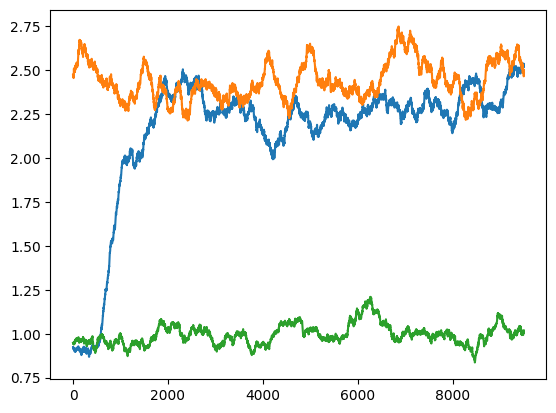

In [ ]:
plt.plot(moving_average(scores, n=500))
plt.plot(moving_average(opt_scores, n=500))
plt.plot(moving_average(rand_scores, n=500))
plt.show()